# Measure preformance of insertion using fragment ID as primary key

**Set environment**

In [1]:
#######################################################
### Set environment
###++++++++++++++++++++++++++++++++++++++++++++++++++++

### import common packages
import numpy  as np
import itertools as it
import sys, os, gzip
from   functools import reduce

### update print
from functools import partial
print = partial(print, flush=True)

### set working directories
FD_RES = "/gpfs/fs1/data/reddylab/Kuei/out/proj_combeffect"

### import specific packages
import sqlite3
# https://stackoverflow.com/questions/49456158/integer-in-python-pandas-becomes-blob-binary-in-sqlite
sqlite3.register_adapter(np.int64, lambda val: int(val))
sqlite3.register_adapter(np.int32, lambda val: int(val))


### import packages for benchmark performance
import cProfile, pstats, time, timeit
import matplotlib.pyplot as plt

**Global variables of database and file**

In [2]:
#######################################################
### parse arguments
###++++++++++++++++++++++++++++++++++++++++++++++++++++
CHROM   = "chr17"                          #args.chrom
FD_OUT  = os.path.join(FD_RES, "database") #args.fout
FD_INP  = os.path.join(FD_RES, "nuc")      #args.finp
PREFIX  = "test_insert"                    #args.prefix
VERBOSE = True                             #args.verbose

#######################################################
### Global varialbes and I/O
###++++++++++++++++++++++++++++++++++++++++++++++++++++

### file path of fragment database
fdiry  = FD_OUT
fname  = f"{PREFIX}_{CHROM}.db"
FP_DTB = os.path.join(fdiry, fname)

### file path of fragment table
sample  = "Input1_20x"
fdiry   = os.path.join(FD_INP, sample)
fname   = "chr17.bed.gz"
FP_FRG  = os.path.join(fdiry, fname)

### show info
if (VERBOSE):
    print("Global variables:")
    print("Chromsome:  ", CHROM)
    print("Database:   ", FP_DTB)
    print("Input file: ", FP_FRG)
    print()

Global variables:
Chromsome:   chr17
Database:    /gpfs/fs1/data/reddylab/Kuei/out/proj_combeffect/database/test_insert_chr17.db
Input file:  /gpfs/fs1/data/reddylab/Kuei/out/proj_combeffect/nuc/Input1_20x/chr17.bed.gz



## Setup helper function for reading files

In [3]:
##################################################
### Helper functions
### ++++++++++++++++++++++++++++++++++++++++++++++

### helper function to get a chunk of file
def get_chunks(gen, rows=10):
    """Divides the data into chunks with size as rows"""
    iterable = iter(gen)
    while True:
        x = list(it.islice(iterable, rows))
        if not x:
            return
        yield x

### helper function to process each row
def prep_line(line):
    """Function to process each line"""
    ### Decode
    lst = line.decode('ASCII').strip().split('\t') 

    ### parse info
    key = "_".join(lst[0:3])
    val = lst[0:3] + lst[4:-1]
    return [key] + val

def gen_line(file, n_chunksize=None, n_lines=None):
    """generate lines or chunks of lines from the file"""
    ### remove file header
    header = file.readline()
    lines  = file
    
    ### preprocess each line
    fun = prep_line
    gen = map(fun, lines)
    
    ### set number of lines read if specified
    if n_lines is not None:
        gen = it.islice(gen, n_lines)
    
    ### set chunks if specified
    if n_chunksize is not None:
        gen = get_chunks(gen, n_chunksize)

    return gen

## Setup SQL query and functions for creating and inserting into fragment table

In [4]:
##################################################
### Set SQL query
### ++++++++++++++++++++++++++++++++++++++++++++++

query_reset_table = "DROP TABLE IF EXISTS Fragment"

query_table_frag = ("""
    CREATE TABLE IF NOT EXISTS Fragment(
        fragment TEXT PRIMARY KEY, 
        chrom    TEXT,
        start    INTEGER,
        end      INTEGER,
        pct_at   REAL,
        pct_gc   REAL,
        num_A    INTEGER,
        num_C    INTEGER,
        num_G    INTEGER,
        num_T    INTEGER,
        num_N    INTEGER,
        num_oth  INTEGER
    );""")

query_table_auto = ("""
    CREATE TABLE IF NOT EXISTS Fragment(
        fragment TEXT, 
        chrom    TEXT,
        start    INTEGER,
        end      INTEGER,
        pct_at   REAL,
        pct_gc   REAL,
        num_A    INTEGER,
        num_C    INTEGER,
        num_G    INTEGER,
        num_T    INTEGER,
        num_N    INTEGER,
        num_oth  INTEGER
    );""")

query_insert = ("""
    INSERT OR IGNORE INTO Fragment
        (fragment, chrom, start, end, pct_at, pct_gc,
         num_A, num_C, num_G, num_T, num_N, num_oth) 
    VALUES 
        (?,?,?,?,?,?,?,?,?,?,?,?)
    """)

In [5]:
##################################################
### Set database function
### ++++++++++++++++++++++++++++++++++++++++++++++

def refresh(query_table, fpath_database):
    """
    Helper function to refresh the database by 
    deleting original table and create a new one
    """
    with sqlite3.connect(fpath_database) as conn:
        ### init
        cursor = conn.cursor()

        ### reset table
        query  = query_reset_table
        cursor = cursor.execute(query)

        ### create table
        query  = query_table
        cursor = cursor.execute(query)
        
def insert_line_by_line(n_lines, query_table, fpath_database, fpath_table):
    """Helper function to insert rows into table line by line"""
    
    ### init a new table
    refresh(query_table, fpath_database)
    
    with sqlite3.connect(fpath_database) as conn:
        ### initiation
        cursor = conn.cursor()
        query  = query_insert
        
        ### read file
        with gzip.open(fpath_table, "rb") as file:
            
            ### generate lines
            lines = gen_line(file, n_lines=n_lines)

            ### insert line by line
            for line in lines:
                cursor.execute(query, line)
                
def insert_line_by_chunk(n_lines, n_chunksize, query_table, fpath_database, fpath_table):
    """Helper function to insert rows into table by chunk"""
    ### init a new table
    refresh(query_table, fpath_database)
    
    with sqlite3.connect(fpath_database) as conn:
        ### initiation
        cursor = conn.cursor()
        query  = query_insert
        
        ### read file
        with gzip.open(fpath_table, "rb") as file:
            
            ### generate chunks
            chunks = gen_line(file, n_chunksize=n_chunksize, n_lines=n_lines)
            
            ### insert chunk by chunk
            for chunk in chunks:
                cursor.executemany(query, chunk)

In [6]:
def check_table_size(n_lines, fpath_database=FP_DTB):
    """count the number of rows/lines in a table created in a database"""
    with sqlite3.connect(fpath_database) as conn:
        ### initiation
        cursor = conn.cursor()
        query  = "select count(*) from Fragment"
        
        ### get the table size of table
        cursor = cursor.execute(query)
        counts = cursor.fetchall()
        counts = counts[0][0]
    
    if counts == n_lines:
        print("Check table size:  passed!")    
    else:
        print("Check table size:  failed.")
    

def check_table_lines(fpath_database=FP_DTB, fpath_table=FP_FRG):
    """check the integrity of the table creation"""
    
    def get_line_from_database():
        """generator of lines from database"""
        with sqlite3.connect(fpath_database) as conn:
            ### initiation
            cursor = conn.cursor()
            query  = "select * from Fragment"

            ### get the table size of table
            cursor = cursor.execute(query)
            for line in cursor:
                yield line
                
    def get_line_from_file():    
        """generator of lines from file"""
        with gzip.open(fpath_table, "rb") as file:
            lines = gen_line(file)
            for line in lines:
                yield line
    
    ### compare line by line
    lines_base = get_line_from_database()
    lines_file = get_line_from_file()
    fun = lambda x, y: str(x) == str(y)
    
    for line_base, line_file in zip(lines_base, lines_file):
        ### compare elements for each pair of lines and 
        ### return a list of true/false whether each pair of elements are equal
        res = list(it.starmap(fun, zip(line_base, line_file)))
        
        ### if all elements are equal for each line, continue
        ### if not, exit the function and print the failed message
        if all(res):
            continue
        else:
            print("Check table lines: failed.")
            return
        
    ### all lines are equal
    print("Check table lines: passed!")    

## Measure performance

In [7]:
%%time
time.sleep(2)

CPU times: user 1.39 ms, sys: 1.16 ms, total: 2.55 ms
Wall time: 2 s


**Initialization**

In [8]:
N = 1
R = 2

n_lines     = [10, 100, 1000, 5000, 10000, 50000, 100000]
n_chunksize = [1, 10, 100, 1000]

fpath_database = FP_DTB
fpath_table    = FP_FRG
query_table    = query_table_frag

**Measure time for insert line by line**

In [9]:
%%time
res = list()

for n in n_lines:
    fun = lambda: insert_line_by_line(n, query_table, fpath_database, fpath_table)
    lst = timeit.repeat(fun, number=N, repeat=R)
    res.append(np.min(lst))   
    
res_line = res

CPU times: user 3.43 s, sys: 349 ms, total: 3.78 s
Wall time: 6.72 s


**Measure time for insert line by chunk**

In [10]:
%%time
mat = list()

for c in n_chunksize:
    res = list()
    for n in n_lines:
        print(f"#Lines: {n}; #Chunksize: {c}")
        fun = lambda: insert_line_by_chunk(n, c, query_table, fpath_database, fpath_table)
        lst = timeit.repeat(fun, number=N, repeat=R)
        res.append(np.min(lst))
    mat.append(res)
    
mat_chunk = mat

#Lines: 10; #Chunksize: 1
#Lines: 100; #Chunksize: 1
#Lines: 1000; #Chunksize: 1
#Lines: 5000; #Chunksize: 1
#Lines: 10000; #Chunksize: 1
#Lines: 50000; #Chunksize: 1
#Lines: 100000; #Chunksize: 1
#Lines: 10; #Chunksize: 10
#Lines: 100; #Chunksize: 10
#Lines: 1000; #Chunksize: 10
#Lines: 5000; #Chunksize: 10
#Lines: 10000; #Chunksize: 10
#Lines: 50000; #Chunksize: 10
#Lines: 100000; #Chunksize: 10
#Lines: 10; #Chunksize: 100
#Lines: 100; #Chunksize: 100
#Lines: 1000; #Chunksize: 100
#Lines: 5000; #Chunksize: 100
#Lines: 10000; #Chunksize: 100
#Lines: 50000; #Chunksize: 100
#Lines: 100000; #Chunksize: 100
#Lines: 10; #Chunksize: 1000
#Lines: 100; #Chunksize: 1000
#Lines: 1000; #Chunksize: 1000
#Lines: 5000; #Chunksize: 1000
#Lines: 10000; #Chunksize: 1000
#Lines: 50000; #Chunksize: 1000
#Lines: 100000; #Chunksize: 1000
CPU times: user 12.4 s, sys: 1.63 s, total: 14 s
Wall time: 29 s


**Results visualization**

In [11]:
### results
results = [res_line] + mat_chunk

In [12]:
### labels for each result
fun = np.core.defchararray.add
idx = np.array(n_chunksize).astype("str")

labels = reduce(fun, ["Chunk (size=", idx, ")"])
labels = np.r_[["Line_by_Line"], labels]
print(labels)

['Line_by_Line' 'Chunk (size=1)' 'Chunk (size=10)' 'Chunk (size=100)'
 'Chunk (size=1000)']


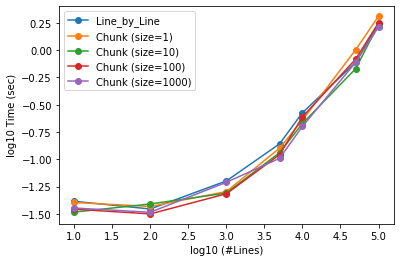

In [13]:
### plot the time vs number lines insert into the database
for res, lab in zip(results, labels):
    plt.plot(np.log10(n_lines), np.log10(res), "-o", label=lab)
plt.legend()
plt.xlabel("log10 (#Lines)")
plt.ylabel("log10 Time (sec)")
plt.show()